## MSDS 462 final 
### Style transfer with OpenCV, Movidius Stick 2 and Torch

In [1]:
# import the necessary packages
from imutils import paths
import itertools
import argparse
import time
import os
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

### Styles images

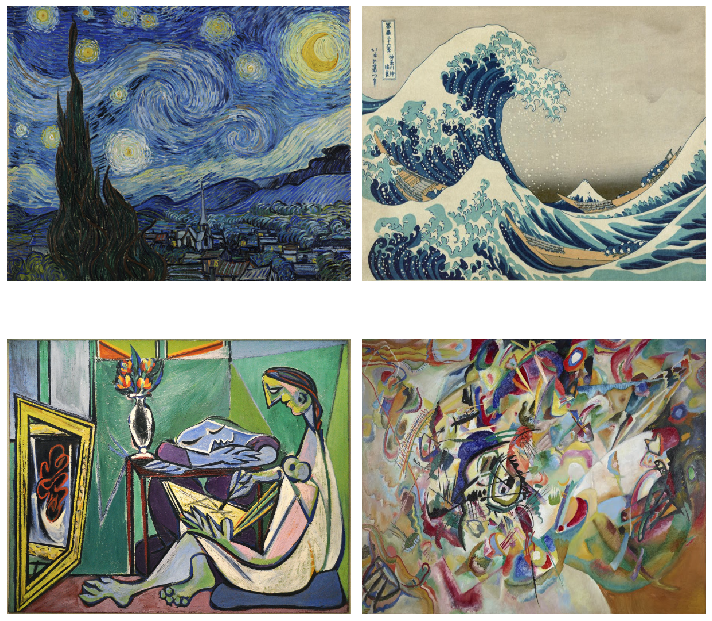

In [2]:
folder='styles'
images= [os.getcwd()+ '/styles/' + f for f in os.listdir('styles')]
fig=plt.figure(figsize=(10, 10))
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i-1])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (600,480))
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img, interpolation='nearest')
plt.tight_layout()
plt.show()

### Get pretrained models

In [3]:
modelPaths = paths.list_files('models/', validExts=(".t7",))
modelPaths = sorted(list(modelPaths))
# generate unique IDs for each of the model paths, then combine the
# two lists together
models = list(zip(range(0, len(modelPaths)), (modelPaths)))
modelIter = itertools.cycle(models)
(modelID, modelPath) = next(modelIter)
models

[(0, 'models/composition_vii.t7'),
 (1, 'models/la_muse.t7'),
 (2, 'models/starry_night.t7'),
 (3, 'models/the_wave.t7')]

In [4]:
source='/Users/CTran/Desktop/test_cam.mov'

In [5]:
def run(net):
    # specify the target device as the Myriad processor on the NCS
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_MYRIAD)
    # initialize the video stream, then allow the camera sensor to warm up
    print("[INFO] starting video stream...")
    cap = cv2.VideoCapture(source)
    # loop over frames from the video file stream
    while(cap.isOpened()):
        # grab the frame from the threaded video stream
        ret, frame = cap.read()
        
        # resize the frame to have a width of 600 pixels (while
        # maintaining the aspect ratio), and then grab the image
        # dimensions
        o_h, o_w = frame.shape[:2]
        frame = cv2.resize(frame, (o_h,600))
        orig = frame.copy()
        (h, w) = frame.shape[:2]
        
        # construct a blob from the frame, set the input, and then perform a
        # forward pass of the network
        blob = cv2.dnn.blobFromImage(frame, 1.0, (w, h),
            (103.939, 116.779, 123.680), swapRB=False, crop=False)
        net.setInput(blob)
        output = net.forward()
        
        # reshape the output tensor, add back in the mean subtraction, and
        # then swap the channel ordering
        output = output.reshape((3, output.shape[2], output.shape[3]))
        output[0] += 103.939
        output[1] += 116.779
        output[2] += 123.680
        output /= 255.0
        output = output.transpose(1, 2, 0)
        
        # show the original frame along with the output neural style
        # transfer
        cv2.imshow("Input", frame)
        cv2.imshow("Output", output)
        key = cv2.waitKey(1) & 0xFF
        # if the `n` key is pressed (for "next"), load the next neural
        # style transfer model
        if key == ord("n"):
            # grab the next nueral style transfer model model and load it
            (modelID, modelPath) = next(modelIter)
            print("[INFO] {}. {}".format(modelID + 1, modelPath))
            net = cv2.dnn.readNetFromTorch(modelPath)

        # otheriwse, if the `q` key was pressed, break from the loop
        elif key == ord("q"):
            break
            
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
print("[INFO] loading style transfer model...")
net = cv2.dnn.readNetFromTorch(modelPath)
run(net)

[INFO] loading style transfer model...
[INFO] starting video stream...
